In [75]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from features_builder import load_and_build
from sklearn.linear_model import LogisticRegression


In [76]:
def analyze_confidence_thresholds(y_test, y_pred, y_pred_proba, thresholds=[0.50,0.55, 0.60, 0.65, 0.70, 0.75]):
    """
    Evaluates accuracy of predictions above selected confidence thresholds.
    Helps determine where the model has real trading edge.
    """

    test_results = pd.DataFrame({
        'actual': y_test.values,
        'predicted': y_pred,
        'proba_down': y_pred_proba[:, 0],
        'proba_up': y_pred_proba[:, 1]
    })

    # Determine confidence score (highest of the two)
    test_results['confidence'] = test_results[['proba_down', 'proba_up']].max(axis=1)

    print("\n===== HIGH-CONFIDENCE TRADE ANALYSIS =====")
    for threshold in thresholds:
        mask = test_results['confidence'] > threshold
        count = mask.sum()

        if count > 0:
            acc = (test_results.loc[mask, 'actual'] == test_results.loc[mask, 'predicted']).mean()
            print(f"Confidence > {threshold}: {count:4d} trades ({count/len(test_results)*100:5.2f}%) - Accuracy: {acc:.4f}")
        else:
            print(f"Confidence > {threshold}: 0 trades")

    return test_results

In [77]:
Baseline_model= LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

In [78]:
model = LGBMClassifier(
            max_depth=2,
            num_leaves=7,
            min_child_samples=100,
            n_estimators=150,
            learning_rate=0.03,
            reg_alpha=1.5,
            reg_lambda=1.5,
            subsample=0.6,
            colsample_bytree=0.6,
            class_weight='balanced',
            random_state=42,
            verbose=-1
        )


In [79]:
feature_cols = [
    'volatility_10', 'volatility_24', 'volatility_168', 'vol_ratio',
    'volume_ratio', 'volume_trend', 'buy_pressure', 'buy_strength',
    'roc_4', 'roc_12', 'roc_24',
    'price_to_sma24', 'sma_cross', 'hl_range', 'hl_range_ma', 'trend_regime',
    'day_of_week', 'hour', 'month',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    # Technical indicators
    'rsi_14', 'rsi_7',
    'macd', 'macd_signal', 'macd_hist',
    'bb_width', 'bb_position',
    'stoch_k', 'stoch_d',
    'atr_14','ema_fast', 'ema_slow',
    'obv_ema','atr_pct',
    'mfi'
] + [f'return_lag_{i}' for i in [1, 2, 3, 4, 6, 8, 12, 24]]


Defining the target  Here target is 1hr means 14 candle

In [80]:
def add_future_returns_aligned(df: pd.DataFrame, horizon_candles: int = 4) -> pd.DataFrame:
    """
    Realistic: decide at close[t], enter at open[t+1], exit at close[t+1+horizon]
    """
    df = df.copy()
    
    # ✅ Entry = next bar's open (realistic execution)
    df["entry_price"] = df["open"].shift(-1)
    
    # ✅ Exit = close after horizon bars from entry
    df["exit_price"] = df["close"].shift(-1 - horizon_candles)
    
    # Return = (exit - entry) / entry
    df["target_log_return"] = np.log(df["exit_price"] / df["entry_price"])
    df["target_simple_return"] = df["exit_price"] / df["entry_price"] - 1
    
    # Clean up
    df = df.dropna(subset=["entry_price", "exit_price"])
    
    return df


In [81]:
import pandas as pd

file_id_1 = "1-FNTi-4fC58YUTH2DR6UsUFnHmcHzEJS"
file_id_2 = "18d-8Z49XLs_GsqFZkCLi8CVLs77YtJqM"


# Create a direct download URL
eth = f"https://drive.google.com/uc?export=download&id={file_id_1}"
btc = f"https://drive.google.com/uc?export=download&id={file_id_2}"

# Load into pandas if they're CSVs
df = pd.read_csv(eth)
# df = pd.read_csv(btc)

In [82]:
df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_buy_base,taker_buy_quote,ignore,funding_rate
0,2019-09-08 00:00:00+00:00,177.58,179.26,177.57,179.11,2239.02187,1567901699999,3.996834e+05,1477,1210.75441,2.160416e+05,0,NaN
1,2019-09-08 00:15:00+00:00,179.15,179.31,178.56,178.64,1008.18424,1567902599999,1.805077e+05,863,385.41225,6.899072e+04,0,NaN
2,2019-09-08 00:30:00+00:00,178.66,178.68,178.31,178.38,537.52722,1567903499999,9.596649e+04,857,274.92446,4.908400e+04,0,NaN
3,2019-09-08 00:45:00+00:00,178.38,179.04,178.35,178.84,1297.58475,1567904399999,2.319474e+05,959,503.45805,8.996389e+04,0,NaN
4,2019-09-08 01:00:00+00:00,178.84,179.30,178.51,178.73,5019.35610,1567905299999,8.985325e+05,1132,2994.15570,5.359537e+05,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218783,2025-12-05 18:15:00+00:00,3051.25,3052.16,3017.17,3028.68,13544.15620,1764959399999,4.108969e+07,107904,5873.59010,1.781025e+07,0,0.000098
218784,2025-12-05 18:30:00+00:00,3028.68,3036.27,3008.44,3011.87,5048.65500,1764960299999,1.525034e+07,80147,2124.77950,6.420908e+06,0,0.000098
218785,2025-12-05 18:45:00+00:00,3011.87,3018.28,3004.10,3007.53,3301.48880,1764961199999,9.938347e+06,58438,1441.89280,4.341149e+06,0,0.000098
218786,2025-12-05 19:00:00+00:00,3007.53,3013.88,2983.08,3011.15,14724.20380,1764962099999,4.412249e+07,124419,7243.89590,2.171117e+07,0,0.000098


In [83]:
## Load the File 

df = load_and_build(eth)
df = add_future_returns_aligned(df, horizon_candles=4)

index=int((df.shape[0]*75)/100)


df["open_time"] = pd.to_datetime(df["open_time"])
df = df.sort_values("open_time")
train_df = df.iloc[:index]
test_df  = df.iloc[index:]


In [84]:
if "target_log_return" not in df.columns:
        raise ValueError(
            "df must contain 'target_log_return'. "
            "Compute it once globally before calling run_window."
        )

    # --- 1) Quantiles ONLY from TRAIN (no leakage) ---
lower = train_df["target_log_return"].quantile(0.05)
upper = train_df["target_log_return"].quantile(0.95)



for d in (train_df, test_df):
        d["target"] = np.where(
            d["target_log_return"] > upper,
            1,
            np.where(d["target_log_return"] < lower, 0, np.nan),
        )


C:\Users\amank\AppData\Local\Temp\ipykernel_3812\3358430910.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["target"] = np.where(
C:\Users\amank\AppData\Local\Temp\ipykernel_3812\3358430910.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["target"] = np.where(


In [85]:
 # --- 3) Drop rows with NaN in features or target ---
train_df = train_df.dropna(subset=feature_cols + ["target"])
test_df  = test_df.dropna(subset=feature_cols + ["target"])


X_train, y_train = train_df[feature_cols], train_df["target"]
X_test,  y_test  = test_df[feature_cols],  test_df["target"]


In [86]:
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


In [87]:
Baseline_model.fit(X_train, y_train)


y_pred_baseline = model.predict(X_test)
y_proba_baseline = model.predict_proba(X_test)

In [88]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, confusion_matrix
)
import numpy as np


def evaluate_model_fit(model, X_train, y_train, X_test, y_test, name="Model", threshold=0.5):
    """
    Evaluate classification performance of a machine learning model on
    train and test sets, and detect potential overfitting.

    Metrics:
        - Accuracy
        - Precision
        - Recall
        - F1 Score
        - AUC (if predict_proba available)
        - Log Loss
        - Generalization gap (train vs test)
    """

    # --- Predictions ---
    if hasattr(model, "predict_proba"):
        train_proba = model.predict_proba(X_train)[:, 1]
        test_proba = model.predict_proba(X_test)[:, 1]

        train_pred = (train_proba >= threshold).astype(int)
        test_pred = (test_proba >= threshold).astype(int)
    else:
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_proba = None
        test_proba = None

    # --- Metric function ---
    def compute_metrics(y_true, y_pred, proba=None):
        metrics = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
        }
        if proba is not None:
            try:
                metrics["auc"] = roc_auc_score(y_true, proba)
                metrics["logloss"] = log_loss(y_true, proba)
            except:
                metrics["auc"] = None
                metrics["logloss"] = None
        return metrics

    # --- Get metrics ---
    train_metrics = compute_metrics(y_train, train_pred, train_proba)
    test_metrics  = compute_metrics(y_test,  test_pred,  test_proba)

    # --- Overfitting detection using F1 ---
    train_f1 = train_metrics["f1"]
    test_f1  = test_metrics["f1"]

    generalization_gap = (train_f1 - test_f1) / (abs(train_f1) + 1e-9)
    overfit_flag = generalization_gap > 0.20  # >20% gap = likely overfitting

    # --- Print Summary ---
    print(f"\n========== {name} Classification Report ==========")
    print("Train:")
    print(train_metrics)
    print("\nTest:")
    print(test_metrics)

    # --- Prepare return report ---
    return {
        "name": name,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics
    }


In [89]:
basemodel_result=evaluate_model_fit(Baseline_model, X_train, y_train, X_test, y_test, name="Model")


========== Model Classification Report ==========
Train:
{'accuracy': 0.5498835641622748, 'precision': 0.545352365966056, 'recall': 0.5951913640824338, 'f1': 0.5691829432811308, 'auc': 0.5657236063651748, 'logloss': 0.6862908048388655}

Test:
{'accuracy': 0.5556771545827633, 'precision': 0.5479723046488625, 'recall': 0.3219058686809994, 'f1': 0.4055636896046852, 'auc': 0.5642257844126362, 'logloss': 0.6874146468545271}


In [90]:
complex_model_result=evaluate_model_fit(model, X_train, y_train, X_test, y_test, name="Model")


========== Model Classification Report ==========
Train:
{'accuracy': 0.603750459615149, 'precision': 0.6041512231282431, 'recall': 0.5998527968596663, 'f1': 0.6019943370675859, 'auc': 0.6479180276557795, 'logloss': 0.6643176211481181}

Test:
{'accuracy': 0.5674418604651162, 'precision': 0.5380434782608695, 'recall': 0.5752469494479954, 'f1': 0.5560235888795282, 'auc': 0.6068722220252649, 'logloss': 0.6755873114022147}


In [91]:
test_metric_basemodel=basemodel_result['test_metrics']

In [92]:
test_metric_complexmodel=complex_model_result['test_metrics']

#### Comparsion between both model

In [93]:
import pandas as pd

df_metrics = pd.DataFrame.from_dict(
    {
        "base_model": test_metric_basemodel,
        "complex_model": test_metric_complexmodel
    },
    orient="index"
)

df_metrics


,accuracy,precision,recall,f1,auc,logloss
base_model,0.555677,0.547972,0.321906,0.405564,0.564226,0.687415
complex_model,0.567442,0.538043,0.575247,0.556024,0.606872,0.675587


In [94]:
idx = X_test.index
confidence = y_proba.max(axis=1)
direction = np.where(y_pred == 1, 1, -1)

In [95]:
signals = pd.DataFrame({
        "confidence": confidence,
        "prediction": y_pred,
        "direction": direction,
        "target_log_return": df.loc[idx, "target_log_return"].values,
        "entry_price": df.loc[idx, "entry_price"].values,  # Next bar open
    }, index=idx)

In [96]:
## Filter the signal for confidence >60 %%!
min_confidence=0.6
signals = signals[signals["confidence"] >= min_confidence].copy()
signals = signals.dropna(subset=["entry_price"])

signals["raw_ret"] = signals["direction"] * signals["target_log_return"]
signals['simple_ret'] = np.exp(signals['raw_ret']) - 1

signals

,confidence,prediction,direction,target_log_return,entry_price,raw_ret,simple_ret
164133,0.602935,0.0,-1,0.015259,2898.74,-0.015259,-0.015143
164134,0.606957,0.0,-1,0.023000,2903.30,-0.023000,-0.022738
164135,0.605029,0.0,-1,0.023399,2902.24,-0.023399,-0.023127
164303,0.611833,0.0,-1,0.029056,2941.74,-0.029056,-0.028638
164304,0.611833,0.0,-1,0.024302,2952.05,-0.024302,-0.024009
...,...,...,...,...,...,...,...
218479,0.644957,1.0,1,0.046995,2861.18,0.046995,0.048117
218613,0.619492,1.0,1,0.015023,3188.39,0.015023,0.015136
218673,0.614145,0.0,-1,0.016192,3144.49,-0.016192,-0.016062
218770,0.618456,0.0,-1,-0.025783,3141.46,0.025783,0.026118


In [97]:
base_capital =100
signals['pnl'] = 100 * signals['simple_ret']
signals['capital'] = base_capital + signals['pnl'].cumsum()

In [98]:
# Running peak of equity
signals['peak'] = signals['capital'].cummax()

# Drawdown in dollars
signals['drawdown'] = signals['capital'] - signals['peak']

# Drawdown in percentage
signals['drawdown_pct'] = signals['drawdown'] / signals['peak']
signals

,confidence,prediction,direction,target_log_return,entry_price,raw_ret,simple_ret,pnl,capital,peak,drawdown,drawdown_pct
164133,0.602935,0.0,-1,0.015259,2898.74,-0.015259,-0.015143,-1.514282,98.485718,98.485718,0.000000,0.000000
164134,0.606957,0.0,-1,0.023000,2903.30,-0.023000,-0.022738,-2.273760,96.211958,98.485718,-2.273760,-0.023087
164135,0.605029,0.0,-1,0.023399,2902.24,-0.023399,-0.023127,-2.312728,93.899230,98.485718,-4.586488,-0.046570
164303,0.611833,0.0,-1,0.029056,2941.74,-0.029056,-0.028638,-2.863822,91.035408,98.485718,-7.450311,-0.075649
164304,0.611833,0.0,-1,0.024302,2952.05,-0.024302,-0.024009,-2.400923,88.634485,98.485718,-9.851234,-0.100027
...,...,...,...,...,...,...,...,...,...,...,...,...
218479,0.644957,1.0,1,0.046995,2861.18,0.046995,0.048117,4.811651,951.822994,951.822994,0.000000,0.000000
218613,0.619492,1.0,1,0.015023,3188.39,0.015023,0.015136,1.513617,953.336611,953.336611,0.000000,0.000000
218673,0.614145,0.0,-1,0.016192,3144.49,-0.016192,-0.016062,-1.606161,951.730450,953.336611,-1.606161,-0.001685
218770,0.618456,0.0,-1,-0.025783,3141.46,0.025783,0.026118,2.611792,954.342242,954.342242,0.000000,0.000000


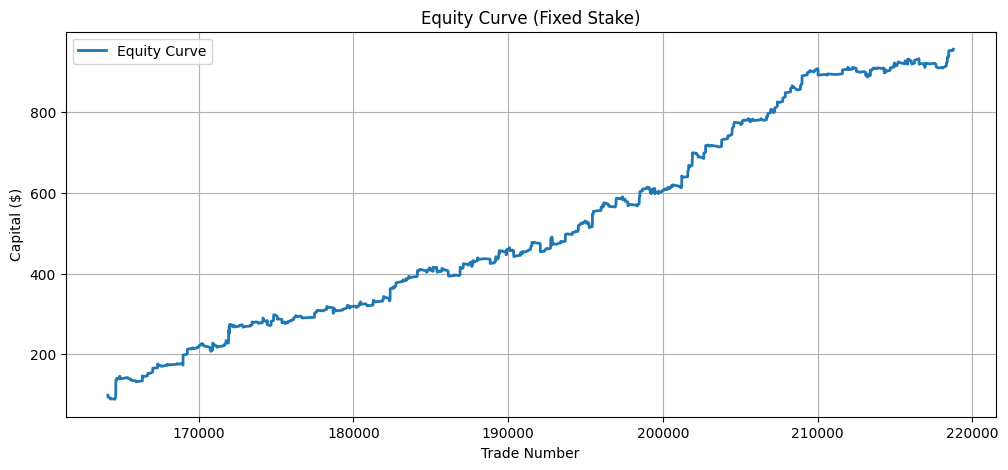

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(signals['capital'], label='Equity Curve', linewidth=2)
plt.title("Equity Curve (Fixed Stake)")
plt.xlabel("Trade Number")
plt.ylabel("Capital ($)")
plt.legend()
plt.grid(True)
plt.show()


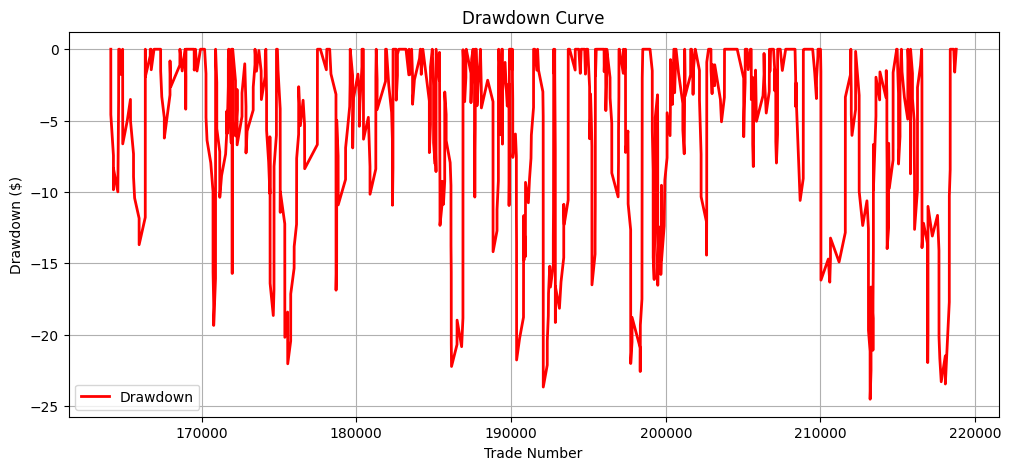

In [100]:
plt.figure(figsize=(12,5))
plt.plot(signals['drawdown'], color='red', label='Drawdown', linewidth=2)
plt.title("Drawdown Curve")
plt.xlabel("Trade Number")
plt.ylabel("Drawdown ($)")
plt.legend()
plt.grid(True)
plt.show()
